In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

set_config(display="text")  # displays text representation of estimators

/tmp/ipykernel_28147/839778002.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [14]:
X, y = load_breast_cancer()
Xt_onehot = OneHotEncoder().fit_transform(X)
pipe = make_pipeline(
    OneHotEncoder(),
    StandardScaler(),
)
Xt = pipe.fit_transform(X)

# Xt.round(2).head()

In [40]:
alphas = 10.0 ** np.linspace(-4, 4, 50)
coefficients = {}
coefficients_onehot = {}

Xt_kinds = [Xt_onehot, Xt]
coeff_kinds = [coefficients_onehot, coefficients]

for i, (Xs, coeffs) in enumerate(zip(Xt_kinds, coeff_kinds)):
    cph = CoxPHSurvivalAnalysis()
    for alpha in alphas:
        cph.set_params(alpha=alpha)
        cph.fit(Xs, y)
        key = round(alpha, 5)
        coeffs[key] = cph.coef_

    coeffs = pd.DataFrame.from_dict(coeffs).rename_axis(
        index="feature", columns="alpha").set_index(Xt_onehot.columns)
    
    coeff_kinds[i] = coeffs

In [41]:
def plot_coefficients(coefs, n_highlight, title=None):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(
        abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ",
                 horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    if title is not None:
        ax.set_title(title)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

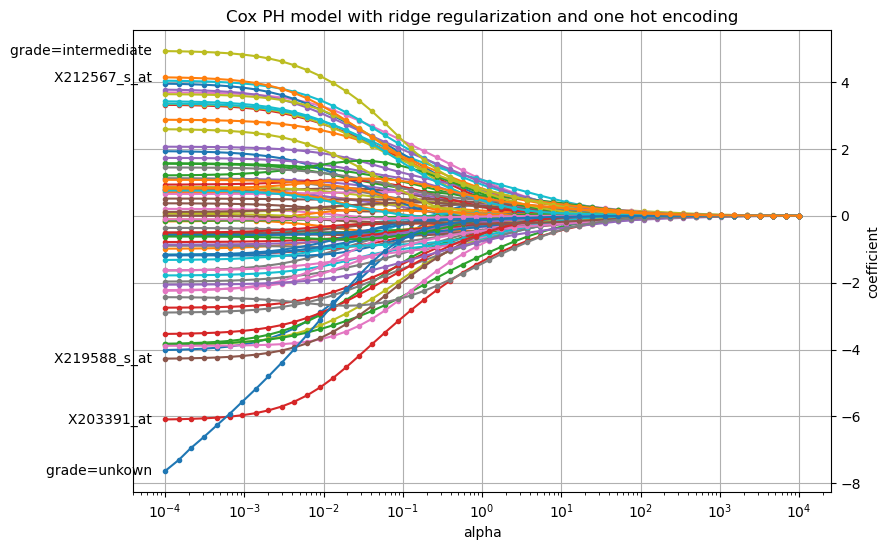

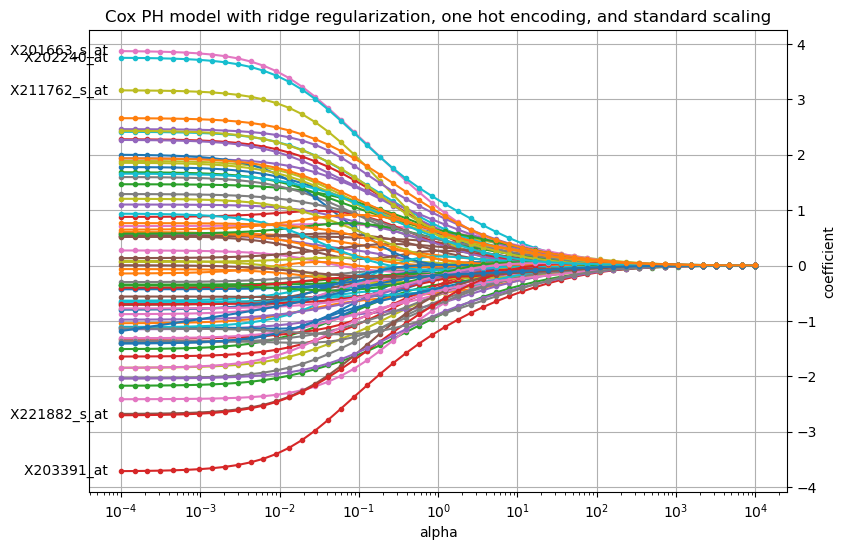

In [47]:
plot_coefficients(coeff_kinds[0], n_highlight=5, title="Cox PH model with ridge regularization and one hot encoding")
plot_coefficients(coeff_kinds[1], n_highlight=5, title="Cox PH model with ridge regularization, one hot encoding, and standard scaling")

In [43]:
coeff_kinds_lasso = []
for i, Xs in enumerate(Xt_kinds):
    cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
    cox_lasso.fit(Xs, y)

    coefficients_lasso = pd.DataFrame(
        cox_lasso.coef_, index=Xt_onehot.columns, columns=np.round(cox_lasso.alphas_, 5))
    
    coeff_kinds_lasso.append(coefficients_lasso)

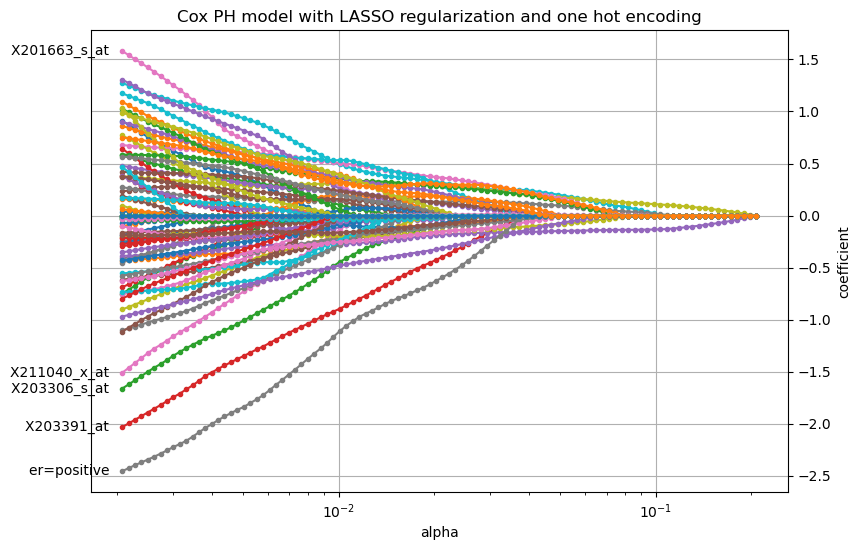

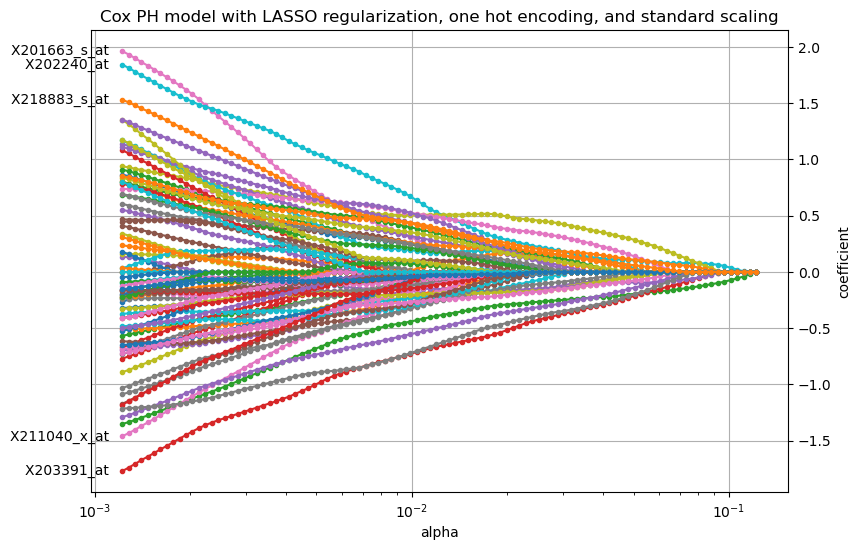

In [48]:
plot_coefficients(coeff_kinds_lasso[0], n_highlight=5,
                  title="Cox PH model with LASSO regularization and one hot encoding")
plot_coefficients(coeff_kinds_lasso[1], n_highlight=5,
                  title="Cox PH model with LASSO regularization, one hot encoding, and standard scaling")

In [49]:
coeff_kinds_elastic_net = []
for i, Xs in enumerate(Xt_kinds):
    cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
    cox_elastic_net.fit(Xs, y)

    coefficients_elastic_net = pd.DataFrame(
        cox_elastic_net.coef_, index=Xt_onehot.columns, columns=np.round(cox_elastic_net.alphas_, 5))

    coeff_kinds_elastic_net.append(coefficients_elastic_net)

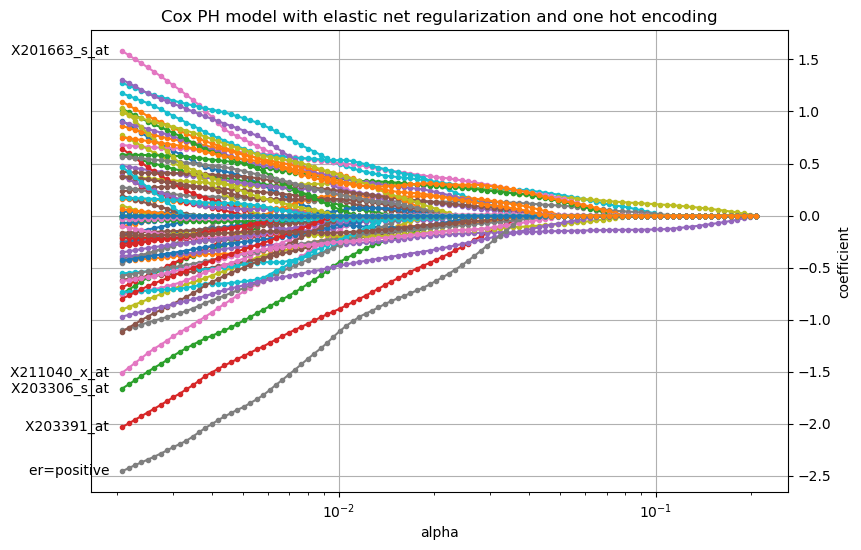

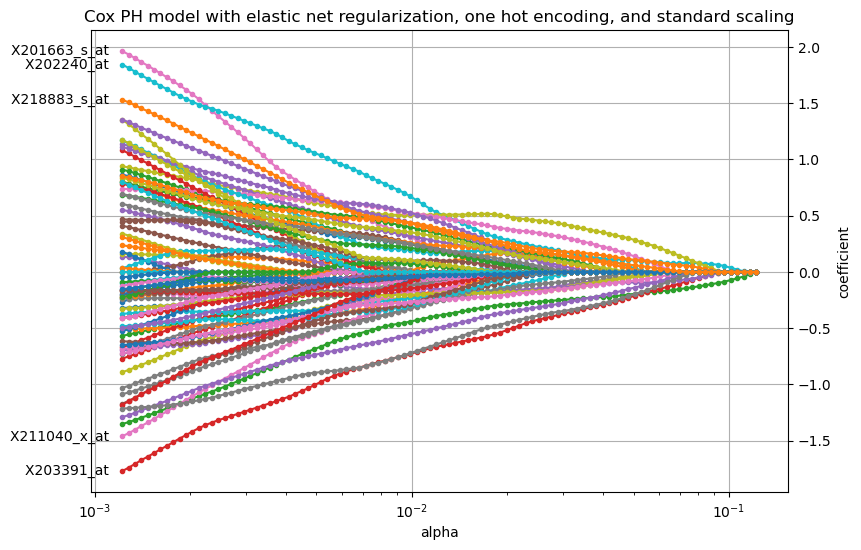

In [50]:
plot_coefficients(coeff_kinds_lasso[0], n_highlight=5,
                  title="Cox PH model with elastic net regularization and one hot encoding")
plot_coefficients(coeff_kinds_lasso[1], n_highlight=5,
                  title="Cox PH model with elastic net regularization, one hot encoding, and standard scaling")